# TransBE

## 01 scRNA-seq DataArry

In [49]:
from scipy.sparse import coo_matrix
from scipy.io import mmread
import os
import pandas as pd

def mtx2csv(Dir="./",Output="./Output.csv.gz"):
    Data = mmread(os.path.join(Dir, "matrix.mtx"))
    Gene_Name = pd.read_table(os.path.join(Dir, "genes.tsv"),header=None)
    Cell_Name = pd.read_table(os.path.join(Dir, "barcodes.tsv"),header=None)
    Matrix = pd.DataFrame(Data.toarray().T, index=Cell_Name[0].to_list(), columns=Gene_Name[1].to_list())
    Matrix.to_csv(Output, compression='gzip')

mtx2csv(Dir="../../../Experiment/ICC-Data/RAW/GSE125449/S2/",Output="../Data/Sample2.csv.gz")

## 02 不同批次数据比较

In [48]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

def Classification(filepath):
    #Data = pd.read_csv(filepath, index_col=0)

    adata = sc.read(filepath)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_cells(adata, max_genes=30000)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    Data = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata,resolution=0.95)
    
    Leiden = pd.DataFrame(adata.obs["leiden"], index=adata.obs_names)
    Data = pd.concat([Data, Leiden], axis=1, join="inner")
    return Data

Data1 = Classification("../Data/Sample1.csv.gz")
Data2 = Classification("../Data/Sample2.csv.gz")
Keys = list(set(Data1.columns) & set(Data2.columns))
Data1 = Data1[Keys]
Data2 = Data2[Keys]
Data1 = Data1.sort_values("leiden")
Data2 = Data2.sort_values("leiden")

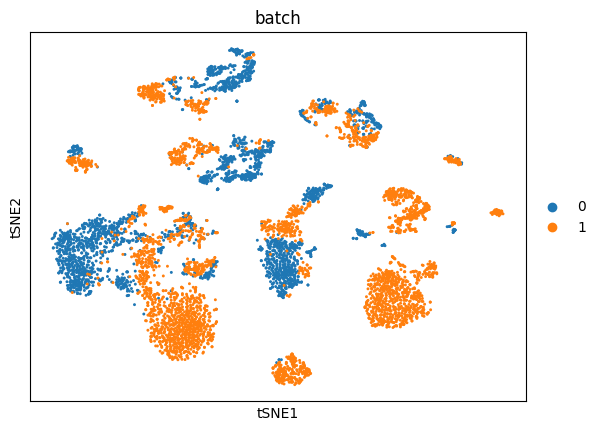

In [22]:
adata1 = sc.read("../Data/Sample1.csv.gz")
adata1.var_names_make_unique()
adata2 = sc.read("../Data/Sample2.csv.gz")
adata2.var_names_make_unique()
adata = adata1.concatenate(adata2, join="inner")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=30000)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
Data1_RAW = adata.X
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata,resolution=0.95)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color="batch")

In [41]:
sum(adata.X[3,:])

-250.3282772526145

In [ ]:
# > Calculate Loss
#   1. Identify the nearest cluster
#   2. calculate distences
#   3. inner divided outer

import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm


def Calculate_Distance(A, B):
    # A is a matrix which size is (m, k)
    # B is a matrix which size is (n, k)
    # D is a matrix which size is (m, n)
    m = np.shape(A)[0]
    n = np.shape(B)[0]
    D = np.zeros((m,n))

    M = np.dot(A, B.T)
    H1 = np.square(A).sum(axis=1) # (1, n) Vector
    H2 = np.square(B).sum(axis=1) # (1, m) Vector
    D = np.sqrt(-2*M + np.matrix(H2) + np.matrix(H1).T)
    return D

def Calculate_PCA(Data, N):
    pca = PCA(n_components=N)
    pca_results = pca.fit(Data)
    D = pca.fit_transform(Data)
    return D

def Calculate_Normalize(Matrix):
    # Normalize
    for i, index in enumerate(tqdm(range(Matrix.shape[0]))):
        Line = Matrix.iloc[index,:]
        Min = min(Line.to_list())
        Max = max(Line.to_list())
        Matrix.iloc[index,:] = (Line - Min) / (Max-Min)
    return Matrix

def Calculate_Loss(Data1, Data2):
    Data_All = pd.concat([Data1.drop(["leiden"], axis=1), Data2.drop(["leiden"], axis=1)])
    Data_All = Calculate_PCA(Data_All, N=50)
    D1 = Data_All[0:Data1.shape[0], :]
    D2 = Data_All[Data1.shape[0]:, :]
    Distance_Matrix = Calculate_Distance(D1, D2)
    Distance_Matrix = pd.DataFrame(Distance_Matrix)
    Distance_Matrix = Distance_Matrix.set_index(Data1.index)
    Distance_Matrix.columns = Data2.index
    Distance_Matrix = Calculate_Normalize(Distance_Matrix)

    Loss_list = []
    for i, Barcode2 in enumerate(tqdm(list(Distance_Matrix.columns))):
        Closest_point = Distance_Matrix[Barcode2].sort_values().index[0]
        c1 = Data1.loc[Closest_point, "leiden"]
        Barcode1 = list(Data1[Data1["leiden"]==c1].index)
        Distance_In_Group = Distance_Matrix.loc[Barcode1, Barcode2].mean()
        Distance_Out_Group = Distance_Matrix.drop(Barcode1)[Barcode2].mean()
        Loss = Distance_In_Group/Distance_Out_Group
        Loss_list.append(Loss)
    Loss_all = np.mean(Loss_list)
    print(Loss_list[0:5])
    return Loss_all

Loss_all = Calculate_Loss(Data1, Data2)

## 03 GPU实现计算

In [50]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
torch.set_printoptions(precision=10)


def Calculate_PCA(Data, N):
    pca = PCA(n_components=N)
    pca_results = pca.fit(Data)
    D = pca.fit_transform(Data)
    return D

def Calculate_Distance(A, B):
    m = A.shape[0]
    n = B.shape[0]
    D = torch.zeros([m ,n])

    M = torch.matmul(A, B.T)
    H1 = torch.sum(torch.square(A), axis=1).reshape(1,-1)
    H2 = torch.sum(torch.square(B), axis=1).reshape(1,-1)
    D = torch.sqrt(-2*M + H2 + H1.T)
    return D

def Calculate_Normalize(Matrix):
    # Normalize
    for i, index in enumerate(tqdm(range(Matrix.shape[0]))):
        Line = Matrix[index,:]
        Min = torch.min(Line)
        Max = torch.max(Line)
        Matrix[index,:] = (Line - Min) / (Max-Min)
    return Matrix



Data_All = pd.concat([Data1.drop(["leiden"], axis=1), Data2.drop(["leiden"], axis=1)])
Data_All = Calculate_PCA(Data_All, N=50)
D1 = Data_All[0:Data1.shape[0], :]
D2 = Data_All[Data1.shape[0]:, :]
D1 = torch.FloatTensor(D1).cuda()
D2 = torch.FloatTensor(D2).cuda()
Distance_Matrix = Calculate_Distance(D1, D2)
Distance_Matrix = Calculate_Normalize(Distance_Matrix)
Leiden1 = torch.FloatTensor(list(map(int, Data1["leiden"].to_list()))).cuda().reshape(-1,1)
Leiden2 = torch.FloatTensor(list(map(int, Data2["leiden"].to_list())))
Leiden2 = torch.cat((Leiden2, torch.tensor([-1])), 0).cuda().reshape(1,-1)
Distance_Matrix = torch.cat((Distance_Matrix, Leiden1), 1)
Distance_Matrix = torch.cat((Distance_Matrix, Leiden2), 0)

i_max = Distance_Matrix.shape[0] - 1
j_max = Distance_Matrix.shape[1] - 1
Loss_list = torch.zeros([j_max+1]).cuda()
Distance_Min_Index = torch.argmin(Distance_Matrix[:-1,:],dim=0)

for i,Index in enumerate(tqdm(Distance_Min_Index)):
    Cluster1 = Distance_Matrix[Index, -1]
    Mask1 = (Distance_Matrix[:,-1] == Cluster1)[:-1]
    Distance_List = Distance_Matrix[:-1,i]
    Distance_In_Group = torch.mean(Distance_List[Mask1])
    Distance_Out_Group = torch.mean(Distance_List[Mask1 == False])
    Loss_list[i] = Distance_In_Group/Distance_Out_Group
Loss_All = torch.mean(Loss_list)
print(Loss_All)

100%|██████████| 3894/3894 [00:02<00:00, 1927.61it/s]

tensor(0.5114863515, device='cuda:0')


## 04 散点图

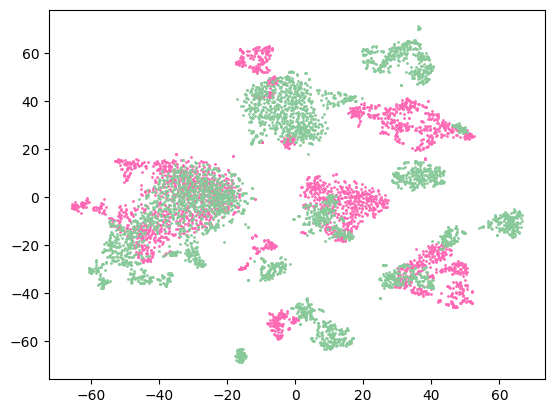

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def Plot_Tsne(PCA1, PCA2, seed=42):
    tsne1 = TSNE(n_components=2, init='pca', random_state=seed)
    result1 = tsne1.fit_transform(PCA1)
    tsne2 = TSNE(n_components=2, init='pca', random_state=seed)
    result2 = tsne2.fit_transform(PCA2)

    plt.scatter(result1[:,0],result1[:,1], color="hotpink", s=1)
    plt.scatter(result2[:,0],result2[:,1], color="#88c999", s=1)

Plot_Tsne(D1.cpu(), D2.cpu())

### 05 Transfomer

In [93]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math

Dim = 512
src = tgt = torch.rand(10, 32, Dim).cuda()

class TransBE(nn.Module):
    def __init__(self, d_model) -> None:
        super(TransBE, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=Dim, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=Dim , nhead=1)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)
    def forward(self, src, tgt):
        fea = self.transformer_encoder(src)
        out = self.transformer_decoder(tgt, fea)
        return out

model = TransBE(Dim).cuda()
criteria = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters())

Total_Loss = 0
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(src, tgt)
    loss = criteria(out.contiguous().view(-1, out.size(-1)), tgt.contiguous().view(-1, tgt.size(-1)))/32
    loss.backward()
    optimizer.step()
    Total_Loss += loss
    if (epoch+1) % 100 == 0:
        print("Epoch {} | Loss = {}".format(epoch+1, loss))

Epoch 100 | Loss = 50.37881088256836
Epoch 200 | Loss = 50.154930114746094
Epoch 300 | Loss = 50.05778121948242
Epoch 400 | Loss = 49.986663818359375
Epoch 500 | Loss = 49.94149398803711
Epoch 600 | Loss = 49.90080642700195
Epoch 700 | Loss = 49.86530685424805
Epoch 800 | Loss = 49.849586486816406
Epoch 900 | Loss = 49.84933090209961
Epoch 1000 | Loss = 49.84907150268555
